In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
"""
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
"""
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import random
import tensorflow as tf
from copy import deepcopy
from pathlib import Path
from sklearn import metrics as skmetrics
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
%matplotlib inline

In [3]:
target_shape = (200, 200)

In [4]:
def create_pickle_file(folder, file, data):
    os.makedirs(folder, exist_ok=True)
    with open(os.path.join(folder, file), "wb") as f:
        pickle.dump(data, f)

In [5]:
def read_pickle_file(folder, file):
    with open(os.path.join(folder, file), "rb") as f:
        return pickle.load(f)

In [6]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [7]:
def generate_random_indexes(label_sample_cnt, label_image_cnt, train_labels_cnt):
    cnt = 0
    lst_idx = []
    lst_anc_idx = []
    lst_pos_idx = []
    lst_neg_idx = []
    while cnt < label_sample_cnt:
        start_idx = 0
        end_idx = label_image_cnt - 1
        anc_idx = random.randint(start_idx, end_idx)
        pos_idx = anc_idx
        while pos_idx == anc_idx:
            pos_idx = random.randint(start_idx, end_idx)
        neg_end_idx = ((train_labels_cnt - 1) * label_image_cnt) - 1
        neg_idx = random.randint(start_idx, neg_end_idx)
        if (anc_idx, pos_idx, neg_idx) not in lst_idx:
            lst_idx.append((anc_idx, pos_idx, neg_idx))
            lst_anc_idx.append(anc_idx)
            lst_pos_idx.append(pos_idx)
            lst_neg_idx.append(neg_idx)
            cnt += 1

    # print(lst_idx)
    return lst_anc_idx, lst_pos_idx, lst_neg_idx

In [8]:
base_input_path = "/kaggle/input/neu-surface-defect-database/NEU-DET"
train_path = os.path.join(base_input_path, "train")
train_images_path = os.path.join(train_path, "images")
# os.listdir(train_images_path)[:6]
# os.listdir(train_path)[:5]
# os.listdir(base_input_path)[:5]
# For FSL train set, consider labels: crazing, inclusion, patches
train_labels = ["crazing", "inclusion", "patches"]
train_sample_cnt = 12000
embedding_size = 2048 # 256
random.seed(10)

In [9]:
anc_images = []
pos_images = []
neg_images = []

for label in train_labels:
    label_train_images_path = os.path.join(train_images_path, label)
    label_train_images = sorted(os.listdir(label_train_images_path), key=lambda x: int(x.split(".jpg")[0].split("_")[-1]))
    label_train_images = [os.path.join(label_train_images_path, img) for img in label_train_images]
    
    train_labels_cnt = len(train_labels)
    label_sample_cnt = train_sample_cnt / train_labels_cnt
    label_image_cnt = len(label_train_images)
    lst_anc_idx, lst_pos_idx, lst_neg_idx = generate_random_indexes(label_sample_cnt, label_image_cnt, train_labels_cnt)
    lst_anc_images = [label_train_images[idx] for idx in lst_anc_idx]
    lst_pos_images = [label_train_images[idx] for idx in lst_pos_idx]
    
    other_labels = deepcopy(train_labels)
    other_labels.remove(label)
    other_labels_train_images = []
    for other_label in other_labels:
        other_label_train_images_path = os.path.join(train_images_path, other_label)
        other_label_train_images = sorted(os.listdir(other_label_train_images_path), key=lambda x: int(x.split(".jpg")[0].split("_")[-1]))
        other_label_train_images = [os.path.join(other_label_train_images_path, img) for img in other_label_train_images]
        other_labels_train_images.extend(other_label_train_images)
        
    lst_neg_images = [other_labels_train_images[idx] for idx in lst_neg_idx]
    
    anc_images.extend(lst_anc_images)
    pos_images.extend(lst_pos_images)
    neg_images.extend(lst_neg_images)

print("total anchor images:", len(anc_images))
print("total pos images:", len(pos_images))
print("total neg images:", len(neg_images))

total anchor images: 12000
total pos images: 12000
total neg images: 12000


In [10]:
# lst_anc_idx, lst_pos_idx, lst_neg_idx = generate_random_indexes(400, 240, 3)
# print(lst_anc_idx, lst_pos_idx, lst_neg_idx)

In [11]:
"""
anc_images = []
pos_images = []
neg_images = []
other_label_cnt = {}

for label in train_labels:
    label_train_images_path = os.path.join(train_images_path, label)
    label_train_images = sorted(os.listdir(label_train_images_path), key=lambda x: int(x.split(".jpg")[0].split("_")[-1]))
    # print(f"*** {label} train images:", label_train_images)
    # print("\n")    
    
    anc_label_train_images = [os.path.join(label_train_images_path, img) for img in label_train_images[:(len(label_train_images)//2)]]
    pos_label_train_images = [os.path.join(label_train_images_path, img) for img in label_train_images[(len(label_train_images)//2):]]
    
    other_labels = deepcopy(train_labels)
    other_labels.remove(label)
    # print(other_labels)
    for other_label in other_labels:
        other_label_cnt[other_label] = 1 if other_label not in other_label_cnt.keys() else other_label_cnt[other_label] + 1

        other_label_train_images_path = os.path.join(train_images_path, other_label)
        other_label_train_images = sorted(os.listdir(other_label_train_images_path), key=lambda x: int(x.split(".jpg")[0].split("_")[-1]))
        
        start_idx = ((other_label_cnt[other_label] - 1) * len(other_label_train_images))//4
        end_idx = (other_label_cnt[other_label] * len(other_label_train_images))//4
        
        neg_label_train_images = [os.path.join(other_label_train_images_path, img) for img in other_label_train_images[start_idx: end_idx]]     
        
        # print(f"*** {other_label} neg images:", neg_label_train_images)
        # print("\n")   
        neg_images.extend(neg_label_train_images)
    
    # print(f"*** {label} anchor images:", anc_label_train_images)
    # print("\n")
    anc_images.extend(anc_label_train_images)
    pos_images.extend(pos_label_train_images)

print("total anchor images:", len(anc_images))
print("total pos images:", len(pos_images))
print("total neg images:", len(neg_images))
"""

'\nanc_images = []\npos_images = []\nneg_images = []\nother_label_cnt = {}\n\nfor label in train_labels:\n    label_train_images_path = os.path.join(train_images_path, label)\n    label_train_images = sorted(os.listdir(label_train_images_path), key=lambda x: int(x.split(".jpg")[0].split("_")[-1]))\n    # print(f"*** {label} train images:", label_train_images)\n    # print("\n")    \n    \n    anc_label_train_images = [os.path.join(label_train_images_path, img) for img in label_train_images[:(len(label_train_images)//2)]]\n    pos_label_train_images = [os.path.join(label_train_images_path, img) for img in label_train_images[(len(label_train_images)//2):]]\n    \n    other_labels = deepcopy(train_labels)\n    other_labels.remove(label)\n    # print(other_labels)\n    for other_label in other_labels:\n        other_label_cnt[other_label] = 1 if other_label not in other_label_cnt.keys() else other_label_cnt[other_label] + 1\n\n        other_label_train_images_path = os.path.join(train_imag

In [12]:
anc_dataset = tf.data.Dataset.from_tensor_slices(anc_images)
pos_dataset = tf.data.Dataset.from_tensor_slices(pos_images)
neg_dataset = tf.data.Dataset.from_tensor_slices(neg_images)

In [13]:
dataset = tf.data.Dataset.zip((anc_dataset, pos_dataset, neg_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

In [14]:
image_count = len(anc_images)

# Let's now split our dataset in train and validation.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

In [15]:
train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

val_dataset = val_dataset.batch(32, drop_remainder=False)
val_dataset = val_dataset.prefetch(8)

In [16]:
def show(ax, image):
    ax.imshow(image)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

def viz(anc, pos, neg):
    records = min(len(anc), 5)
    
    fig = plt.figure()
    ax = fig.subplots(5, 3)
        
    for i in range(records):
        show(ax[i, 0], anc[i])
        show(ax[i, 1], pos[i])
        show(ax[i, 2], neg[i])

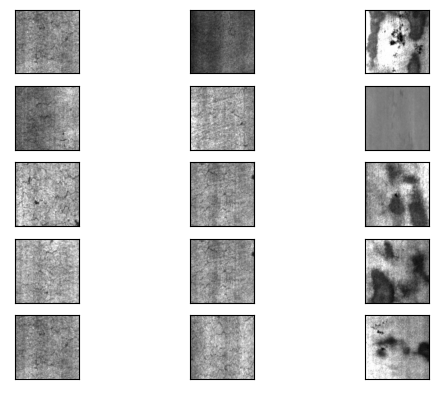

In [17]:
# Pulls the 1st batch - .take(1) - from the train_dataset
viz(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [18]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)
# base_cnn.summary()

94765736/94765736 [==============================] - 3s 0us/step


In [19]:
flatten = layers.Flatten()(base_cnn.output)

# dense1 = layers.Dense(512, activation="relu")(flatten)
# dense1 = layers.BatchNormalization()(dense1)
# dense2 = layers.Dense(256, activation="relu")(dense1)
# dense2 = layers.BatchNormalization()(dense2)

dense1 = layers.Dense(4096, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(2048, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)

output = layers.Dense(embedding_size)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

# embedding.summary()

In [20]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anc, pos, neg):
        anc_pos_distance = tf.reduce_sum(tf.square(anc - pos), -1)
        anc_neg_distance = tf.reduce_sum(tf.square(anc - neg), -1)
        return (anc_pos_distance, anc_neg_distance)

In [21]:
anc_input = layers.Input(name="anchor", shape=target_shape + (3,))
pos_input = layers.Input(name="positive", shape=target_shape + (3,))
neg_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anc_input)),
    embedding(resnet.preprocess_input(pos_input)),
    embedding(resnet.preprocess_input(neg_input)),
)

siamese_network = Model(
    inputs=[anc_input, pos_input, neg_input], outputs=distances
)

In [22]:
# siamese_network.summary()

In [23]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super().__init__()
        self.embedding = embedding
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        anc_pos_distance, anc_neg_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = tf.maximum(anc_pos_distance - anc_neg_distance + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [24]:
epochs = 50
learning_rate = 0.0001
margin = 0.5

root_checkpoint_filepath = "/kaggle/working/models/"
os.makedirs(root_checkpoint_filepath, exist_ok=True)
checkpoint_filepath = os.path.join(root_checkpoint_filepath, f"SiameseModel_data{image_count}_ep{epochs}_lr{learning_rate}_mg{margin}.h5")

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True,
                                verbose=1)

siamese_model = SiameseModel(siamese_network, margin=margin)
siamese_model.compile(optimizer=optimizers.Adam(learning_rate))

anc_img, pos_img, neg_img = preprocess_triplets(anc_images[0], pos_images[0], neg_images[0])
siamese_model([tf.expand_dims(anc_img, axis=0), tf.expand_dims(pos_img, axis=0), tf.expand_dims(neg_img, axis=0)])

# siamese_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset)
history = siamese_model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=[model_checkpoint_callback])
print(history)

Epoch 1/50
300/300 [==============================] - ETA: 0s - loss: 0.0642
Epoch 1: val_loss improved from inf to 0.09700, saving model to /kaggle/working/models/SiameseModel_data12000_ep50_lr0.0001_mg0.5.h5
300/300 [==============================] - 134s 395ms/step - loss: 0.0642 - val_loss: 0.0970
Epoch 2/50
300/300 [==============================] - ETA: 0s - loss: 0.0395
Epoch 2: val_loss did not improve from 0.09700
300/300 [==============================] - 105s 350ms/step - loss: 0.0395 - val_loss: 0.1064
Epoch 3/50
300/300 [==============================] - ETA: 0s - loss: 0.0310
Epoch 3: val_loss did not improve from 0.09700
300/300 [==============================] - 103s 345ms/step - loss: 0.0310 - val_loss: 0.1009
Epoch 4/50
300/300 [==============================] - ETA: 0s - loss: 0.0230
Epoch 4: val_loss improved from 0.09700 to 0.04878, saving model to /kaggle/working/models/SiameseModel_data12000_ep50_lr0.0001_mg0.5.h5
300/300 [==============================] - 117s 3

In [25]:
siamese_model.load_weights(checkpoint_filepath)
siamese_model.save(checkpoint_filepath.replace(".h5", ""))

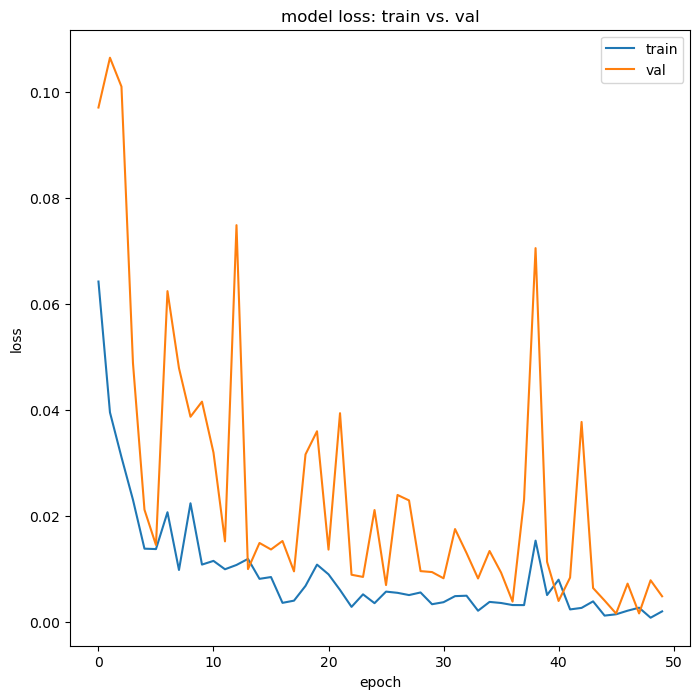

In [26]:
plt.rcParams["figure.figsize"] = (8,8)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss: train vs. val')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

# Implementing 3 way, K shot learning i.e. 3 seen/unseen classes with K images of each class
### Query: generate embeddings for all the test set images in a .pkl file
### Support set: generate mean of embeddings of each class while considering K images of each class. Save this to a .pkl file
### Similarity: compare each test set embedding (Query) with the mean class embedding from the train dataset (Support set mean embedding) using cosine similarity and pick the class with the highest similarity for each (Query) test image.

# Pick the 1st K images from the train set to create a Support set. Then, calculate mean embedding for each of the seen/unseen classes in the Support set.

In [27]:
base_input_path = "/kaggle/input/neu-surface-defect-database/NEU-DET"
trainK_path = os.path.join(base_input_path, "train")
trainK_images_path = os.path.join(train_path, "images")

# Order of class labels is important!!!

# Seen classes: crazing, inclusion, patches
# trainK_labels = ["crazing", "inclusion", "patches"]

# All classes: crazing, inclusion, patches, pitted_surface, rolled-in_scale, scratches
trainK_labels = ["crazing", "inclusion", "patches", "pitted_surface", "rolled-in_scale", "scratches"]

# Unseen labels: pitted_surface, rolled-in_scale, scratches
# trainK_labels = ["pitted_surface", "rolled-in_scale", "scratches"]

k = 5 # eg. k=5 is 5-shot learning

In [28]:
inference_siamese_model = tf.keras.models.load_model(checkpoint_filepath.replace(".h5", ""))
# inference_siamese_model.summary()
inf_embedding = inference_siamese_model.get_layer("Embedding")

In [29]:
# Generate the embeddings for each class label
trainK_label_images_map = {}
trainK_label_emb_mean_map = {}

for label in trainK_labels:
    label_trainK_images_path = os.path.join(trainK_images_path, label)
    label_trainK_images = sorted(os.listdir(label_trainK_images_path), key=lambda x: int(x.split(".jpg")[0].split("_")[-1]))[:k]
    label_trainK_images = [os.path.join(label_trainK_images_path, img) for img in label_trainK_images]
    trainK_label_images_map[label] = label_trainK_images
    
    trainK_label_dataset = tf.data.Dataset.from_tensor_slices(label_trainK_images)
    trainK_label_dataset = trainK_label_dataset.map(preprocess_image)
    trainK_label_dataset = trainK_label_dataset.batch(len(label_trainK_images), drop_remainder=False)
    trainK_full_batch = next(iter(trainK_label_dataset))
    # y_trainK_emb = embedding(resnet.preprocess_input(trainK_full_batch))
    y_trainK_emb = inf_embedding(resnet.preprocess_input(trainK_full_batch))
    y_trainK_emb_mean = tf.reduce_mean(y_trainK_emb, axis=0)
    trainK_label_emb_mean_map[label] = y_trainK_emb_mean.numpy()
    print(y_trainK_emb_mean)

tf.Tensor(
[-3.7684002   1.6577107   0.52175796 ...  2.5865905   4.221572
  0.07206547], shape=(2048,), dtype=float32)
tf.Tensor(
[-3.665937    1.6098791   0.50316584 ...  2.5251458   4.113754
  0.05943887], shape=(2048,), dtype=float32)
tf.Tensor(
[-3.7509105   1.6081785   0.50441134 ...  2.557714    4.14653
  0.06167734], shape=(2048,), dtype=float32)
tf.Tensor(
[-3.6739483   1.6173964   0.50590837 ...  2.5327873   4.129496
  0.06150756], shape=(2048,), dtype=float32)
tf.Tensor(
[-3.7092826   1.6242357   0.5081858  ...  2.548811    4.15158
  0.06326087], shape=(2048,), dtype=float32)
tf.Tensor(
[-3.671287    1.6045758   0.5014676  ...  2.523213    4.1086226
  0.05820201], shape=(2048,), dtype=float32)


In [30]:
# Create a pickle file to store the mean class embeddings for each class
y_trainK_emb_file_map_folder = "/kaggle/working/embeddings/trainK/"
y_trainK_emb_mean_map_file = "y_trainK_emb_mean_map_v1.pkl"
create_pickle_file(y_trainK_emb_file_map_folder, y_trainK_emb_mean_map_file, trainK_label_emb_mean_map)
trainK_label_emb_mean_map = read_pickle_file(y_trainK_emb_file_map_folder, y_trainK_emb_mean_map_file)
# trainK_label_emb_mean_map

# Calculate embeddings for all 3 seen/unseen labels images in the Query (test) set

In [31]:
base_input_path = "/kaggle/input/neu-surface-defect-database/NEU-DET"
test_path = os.path.join(base_input_path, "validation")
test_images_path = os.path.join(test_path, "images")
# os.listdir(test_images_path)[:6]

test_labels = trainK_labels

# For FSL Query (test) set:
# Order of class labels is important!!!
test_seen_labels = ["crazing", "inclusion", "patches"]
test_unseen_labels = ["pitted_surface", "rolled-in_scale", "scratches"]

In [32]:
test_images = []
y_test_gt = []

for label in test_labels:
    label_test_images_path = os.path.join(test_images_path, label)
    label_test_images = sorted(os.listdir(label_test_images_path), key=lambda x: int(x.split(".jpg")[0].split("_")[-1]))
    label_test_images = [os.path.join(label_test_images_path, img) for img in label_test_images]
    test_images.extend(label_test_images)
    # print("labels:", [test_labels.index(label)] * len(label_test_images))
    y_test_gt.extend([test_labels.index(label)] * len(label_test_images))

print("test_images:", len(test_images))
print("y_test_gt:", len(y_test_gt))

test_images: 360
y_test_gt: 360


In [33]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_images)
test_dataset = test_dataset.map(preprocess_image)
test_dataset = test_dataset.batch(len(test_images), drop_remainder=False)
test_full_batch = next(iter(test_dataset))
# y_test_emb = embedding(resnet.preprocess_input(test_full_batch))
y_test_emb = inf_embedding(resnet.preprocess_input(test_full_batch))
y_test_emb

<tf.Tensor: shape=(360, 2048), dtype=float32, numpy=
array([[-3.7724042 ,  1.6755652 ,  0.5319509 , ...,  2.5944786 ,
         4.250811  ,  0.07809323],
       [-3.7575474 ,  1.6585172 ,  0.523439  , ...,  2.5856044 ,
         4.220612  ,  0.0740757 ],
       [-3.7512689 ,  1.6512165 ,  0.5215481 , ...,  2.5789897 ,
         4.207701  ,  0.06857944],
       ...,
       [-3.6753724 ,  1.6259066 ,  0.50719315, ...,  2.533876  ,
         4.1349783 ,  0.06560773],
       [-3.665298  ,  1.6567166 ,  0.51785547, ...,  2.5404873 ,
         4.1830897 ,  0.07455939],
       [-3.6662307 ,  1.6196647 ,  0.5083496 , ...,  2.5276074 ,
         4.1293488 ,  0.06527567]], dtype=float32)>

In [34]:
y_test_emb_file_map = {}
for file, emb in zip(test_images, y_test_emb.numpy()):
    y_test_emb_file_map[file] = emb
    
y_test_emb_file_map_folder = "/kaggle/working/embeddings/test/"
y_test_emb_file_map_file = "y_test_emb_file_map_v1.pkl"
create_pickle_file(y_test_emb_file_map_folder, y_test_emb_file_map_file, y_test_emb_file_map)
y_test_emb_file_map = read_pickle_file(y_test_emb_file_map_folder, y_test_emb_file_map_file)
# y_test_emb_file_map

# Calculate Cosine similarity for the 3 seen & 3 unseen class images in the test set

In [35]:
def calc_cos_sim(a, b):
    norm_a = tf.norm(a, ord="euclidean", axis=-1, keepdims=True)
    norm_b = tf.norm(b, ord="euclidean", axis=-1, keepdims=True)
    cos_sim = tf.matmul(a/norm_a, b/norm_b, transpose_b=True)
    return cos_sim

In [36]:
test_cos_sim = calc_cos_sim(np.array(list(trainK_label_emb_mean_map.values())), np.array(list(y_test_emb_file_map.values())))
test_cos_sim

<tf.Tensor: shape=(6, 360), dtype=float32, numpy=
array([[0.99999124, 0.999999  , 0.99999994, ..., 0.99999714, 0.99997735,
        0.9999956 ],
       [0.99996006, 0.99998206, 0.99998784, ..., 0.9999957 , 0.9999462 ,
        0.9999973 ],
       [0.9999324 , 0.9999603 , 0.9999714 , ..., 0.99998003, 0.9999038 ,
        0.99998224],
       [0.9999671 , 0.9999864 , 0.9999914 , ..., 0.99999774, 0.9999554 ,
        0.9999988 ],
       [0.9999692 , 0.99998766, 0.9999929 , ..., 0.9999976 , 0.9999535 ,
        0.9999986 ],
       [0.99996334, 0.99998397, 0.99998987, ..., 0.9999962 , 0.9999472 ,
        0.99999726]], dtype=float32)>

In [37]:
def calc_max_cos_sim(all_labels, subset_labels, gt, cos_sim):
    # Filter out labels not in test_labels
    label_indexes = [all_labels.index(label) for label in subset_labels]
    image_indexes = []
    subset_gt = []
    for idx, val in enumerate(gt):
        if all_labels[val] in subset_labels:
            image_indexes.append(idx)
            subset_gt.append(val)

    subset_cos_sim = tf.gather(cos_sim, label_indexes, axis=0)
    subset_cos_sim = tf.gather(subset_cos_sim, image_indexes, axis=1)

    subset_pred_argmax = tf.argmax(subset_cos_sim, axis=0)
    subset_pred = [all_labels.index(subset_labels[argmax]) for argmax in subset_pred_argmax]

    return subset_gt, subset_cos_sim, subset_pred

In [38]:
y_test_seen_gt, y_test_seen_cos_sim, y_test_seen_pred = calc_max_cos_sim(test_labels, test_seen_labels, y_test_gt, test_cos_sim)
y_test_seen_gt, y_test_seen_cos_sim, y_test_seen_pred

([0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2,
  2],
 <tf.Tensor: shape=(3, 180), dtype=float32, numpy=
 array([[0.99999124, 0.999999  , 0.99999994, 0.9

In [39]:
y_test_unseen_gt, y_test_unseen_cos_sim, y_test_unseen_pred = calc_max_cos_sim(test_labels, test_unseen_labels, y_test_gt, test_cos_sim)
y_test_unseen_gt, y_test_unseen_cos_sim, y_test_unseen_pred

([3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  5],
 <tf.Tensor: shape=(3, 180), dtype=float32, numpy=
 array([[0.99999833, 0.9999975 , 0.99999714, 0.9

# Generate class metrics for each of the 3 seen & 3 unseen classes

In [40]:
def calc_metrics(labels, gt, pred):
    precision, recall, f1_score, support = skmetrics.precision_recall_fscore_support(np.array(gt), np.array(pred))
    df = pd.DataFrame([labels, precision, recall, f1_score, support], index=['labels', 'precision', 'recall', 'f1_score', "support"]).T
    return df

In [41]:
df_test_seen = calc_metrics(test_seen_labels, y_test_seen_gt, y_test_seen_pred)
df_test_seen

,labels,precision,recall,f1_score,support
0,crazing,1.0,0.816667,0.899083,60
1,inclusion,0.833333,1.0,0.909091,60
2,patches,0.932203,0.916667,0.92437,60


In [42]:
df_test_unseen = calc_metrics(test_unseen_labels, y_test_unseen_gt, y_test_unseen_pred)
df_test_unseen

,labels,precision,recall,f1_score,support
0,pitted_surface,0.318841,0.366667,0.341085,60
1,rolled-in_scale,0.586667,0.733333,0.651852,60
2,scratches,0.305556,0.183333,0.229167,60
